Author: Emily Wong \
December 21, 2023

# 1. Import libraries and data

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Data wrangling
import pandas as pd
import numpy as np
from numpy.random import uniform, normal, seed

In [3]:
data = pd.read_excel("cleaned data.xlsx")
data = data[['pmad','ethnic_group','race','marital_status','age_at_delivery',
             'veteran_status','interpreter_required_yn','zip','insurance',
             'hist_mad','hist_preterm','preterm','csection']]

In [4]:
data = data.dropna()            # keep only complete data (for now)
data = pd.get_dummies(data)     # create one-hot vectors
data = data.sample(len(data))   # randomly shuffle rows

In [5]:
# Machine learning
import sklearn
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
import scipy
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
import matplotlib.pyplot as plt

In [6]:
# TPOT2
from dask.distributed import Client, LocalCluster
import tpot2

In [7]:
# Fairness metrics
import fairlearn
from fairlearn.metrics import demographic_parity_difference, demographic_parity_ratio, equalized_odds_difference, equalized_odds_ratio

The __demographic parity difference__ of 0 means that all groups have the same selection rate. For multiple groups, average across all pairwise differences. Ranges between 0 and 1.

The __demographic parity ratio__ of 1 means that all groups have the same selection rate.

The __equalized odds difference__ of 0 means that all groups have the same true positive, true negative, false positive, and false negative rates.

The __equalized odds ratio__ of 1 means that all groups have the same true positive, true negative, false positive, and false negative rates.

# 2. Handle imbalanced data

In [8]:
# class count
healthy_count, pmad_count = data['pmad'].value_counts()
healthy_count, pmad_count

(29790, 783)

In [9]:
# Separate classes
healthy = data[data['pmad'] == 0]
pmad = data[data['pmad'] == 1]

## 2.1. Over Sampling Minority (PMAD)

In [10]:
seed(0)
pmad_over = pmad.sample(healthy_count, replace=True)
data_over = pd.concat([pmad_over,healthy], axis =0)
print(data_over.shape)

(59580, 324)


In [11]:
# X, y
X = data_over.drop('pmad', axis=1)
y = data_over[['pmad']]

In [12]:
# Split the data into training and test sets
seed(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=0.25)

In [13]:
# Sensitive features
race_feature = X_test[['race_American Indian or Alaska Native',
                       'race_Asian','race_Black or African American',
                       'race_Native Hawaiian or Other Pacific Islander',
                       'race_Multiracial','race_Other','race_Unknown','race_White']]

### 2.1.1. Over: Random Forest

In [14]:
rf = RandomForestClassifier()

seed(0)
parameter_space = {'n_estimators': randint(50,500),
                   'max_depth': randint(1,20)}

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = parameter_space, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train.values.ravel())

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x2935bbad0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x29359a950>})

RF Best hyperparameters: {'max_depth': 19, 'n_estimators': 342}
RF Test Accuracy: 0.72
Demographic parity difference: 0.46
Demographic parity ratio: 0.35
Equalized odds difference: 0.51
Equalized odds ratio: 0.0
RF Confusion Matrix:


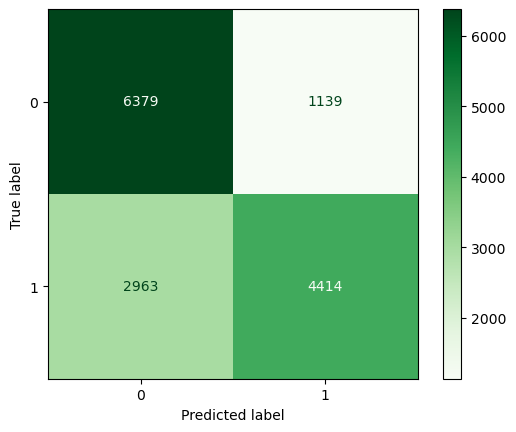

In [15]:
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('RF Best hyperparameters:',  rand_search.best_params_)

# Generate predictions with the best model
y_pred = best_rf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print("RF Test Accuracy:", np.round(test_accuracy,2))

# Fairness metrics
print("Demographic parity difference:",np.round(demographic_parity_difference(y_test, y_pred,sensitive_features=race_feature),2))
print("Demographic parity ratio:",np.round(demographic_parity_ratio(y_test, y_pred,sensitive_features=race_feature),2))
print("Equalized odds difference:",np.round(equalized_odds_difference(y_test, y_pred,sensitive_features=race_feature),2))
print("Equalized odds ratio:",np.round(equalized_odds_ratio(y_test, y_pred,sensitive_features=race_feature),2))

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("RF Confusion Matrix:")
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap=plt.cm.Greens);

### 2.1.2. Over: Neural Network

In [ ]:
nn = MLPClassifier(max_iter=1000, learning_rate_init=0.5)

seed(0)
parameter_space = {'hidden_layer_sizes': [(randint.rvs(1,15,1),randint.rvs(1,15,1),),(randint.rvs(1,15))],
                   'activation': ['tanh', 'relu', 'logistic'],
                   'solver': ['sgd', 'adam', 'lbfgs'],
                   'alpha': uniform(0.0001, 0.9, 3),
                   'learning_rate': ['constant','adaptive']}

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(nn, 
                                 param_distributions = parameter_space, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train.values.ravel())

In [ ]:
best_nn = rand_search.best_estimator_

# Print the best hyperparameters
print('NN Best hyperparameters:',  rand_search.best_params_)

# Generate predictions with the best model
y_pred = best_nn.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print("NN Test Accuracy:", np.round(test_accuracy,2))

# Fairness metrics
print("Demographic parity difference:",np.round(demographic_parity_difference(y_test, y_pred,sensitive_features=race_feature),2))
print("Demographic parity ratio:",np.round(demographic_parity_ratio(y_test, y_pred,sensitive_features=race_feature),2))
print("Equalized odds difference:",np.round(equalized_odds_difference(y_test, y_pred,sensitive_features=race_feature),2))
print("Equalized odds ratio:",np.round(equalized_odds_ratio(y_test, y_pred,sensitive_features=race_feature),2))

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("NN Confusion Matrix:")
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap=plt.cm.Greens);

### 2.1.3. Over: XG Boost

In [16]:
xgb = GradientBoostingClassifier()

seed(0)
parameter_space = {'n_estimators': randint(1,200),
                   'max_depth': randint(1,20),
                   'learning_rate': [uniform(0.000001,0.5),uniform(0.000001,1)],
                   'random_state': randint(0,50)}

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(xgb, 
                                 param_distributions = parameter_space, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train.values.ravel())

RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_iter=5,
                   param_distributions={'learning_rate': [0.2744072031501585,
                                                          0.7151896511830531],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x293559750>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x2a7cacb50>,
                                        'random_state': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x2a7ce5510>})

XG Boost Best hyperparameters: {'learning_rate': 0.2744072031501585, 'max_depth': 18, 'n_estimators': 166, 'random_state': 25}
XG Boost Test Accuracy: 0.81
Demographic parity difference: 0.32
Demographic parity ratio: 0.54
Equalized odds difference: 0.26
Equalized odds ratio: 0.0
XG Boost Confusion Matrix:


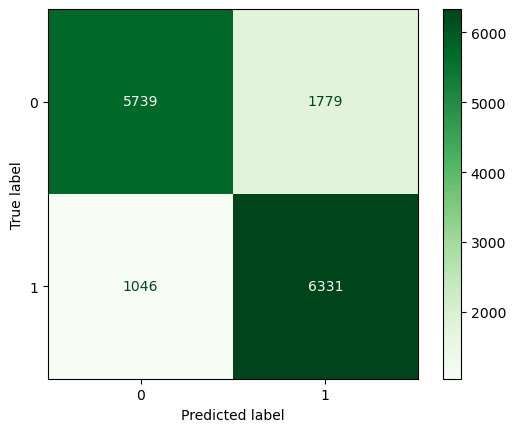

In [17]:
best_xgb = rand_search.best_estimator_

# Print the best hyperparameters
print('XG Boost Best hyperparameters:',  rand_search.best_params_)

# Generate predictions with the best model
y_pred = best_xgb.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print("XG Boost Test Accuracy:", np.round(test_accuracy,2))

# Fairness metrics
print("Demographic parity difference:",np.round(demographic_parity_difference(y_test, y_pred,sensitive_features=race_feature),2))
print("Demographic parity ratio:",np.round(demographic_parity_ratio(y_test, y_pred,sensitive_features=race_feature),2))
print("Equalized odds difference:",np.round(equalized_odds_difference(y_test, y_pred,sensitive_features=race_feature),2))
print("Equalized odds ratio:",np.round(equalized_odds_ratio(y_test, y_pred,sensitive_features=race_feature),2))

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("XG Boost Confusion Matrix:")
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap=plt.cm.Greens);

In [18]:
races = ['race_American Indian or Alaska Native','race_Asian','race_Black or African American',
         'race_Native Hawaiian or Other Pacific Islander','race_Multiracial','race_Other','race_Unknown','race_White']
for r in races:
    race = r
    test_set = pd.concat([y_test,X_test],axis=1)
    group_test_set = test_set[test_set[race]==1]
    group_y_test = group_test_set[['pmad']]
    idx = []
    for i in range(len(test_set)):
        if test_set[race].iloc[i]==1:
            idx.append(i)
    cm = confusion_matrix(group_y_test, y_pred[idx])
    miss = np.round(100*cm[1][0]/sum(sum(cm)),2)
    hit = np.round(100*cm[1][1]/sum(sum(cm)),2)
    print(r,":",miss,"% miss rate")
    print(r,":",hit,"% hit rate")
    #ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap=plt.cm.Greens);

race_American Indian or Alaska Native : 0.0 % miss rate
race_American Indian or Alaska Native : 66.67 % hit rate
race_Asian : 5.49 % miss rate
race_Asian : 39.23 % hit rate
race_Black or African American : 1.48 % miss rate
race_Black or African American : 50.74 % hit rate
race_Native Hawaiian or Other Pacific Islander : 0.0 % miss rate
race_Native Hawaiian or Other Pacific Islander : 37.25 % hit rate
race_Multiracial : 0.0 % miss rate
race_Multiracial : 55.34 % hit rate
race_Other : 0.31 % miss rate
race_Other : 47.6 % hit rate
race_Unknown : 0.0 % miss rate
race_Unknown : 67.11 % hit rate
race_White : 9.8 % miss rate
race_White : 39.96 % hit rate


### 2.1.4. Over: TPOT2

In [ ]:
if __name__=="__main__":
    
    # Get a scorer from string.
    # scoring = method as string (e.g., 'roc_auc_ovr'.
    scorer = sklearn.metrics.get_scorer('roc_auc_ovr')
    
    # Split arrays or matrices into random train and test subsets.
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=0.25)
    
    
    # scorers can be a list of strings or a list of scorers. These get evaluated during cross validation. 
    est = tpot2.TPOTEstimator(scorers=['roc_auc_ovr'],
                              scorers_weights=[1], # positive values = maximize, negative = minimize
                              classification=True,
                              max_eval_time_seconds=120, # Anil: 120
                              #max_time_seconds=15,
                              other_objective_functions=[tpot2.objectives.number_of_nodes_objective], # Anil
                              #generations = 10, # Anil: 10
                              verbose=2,
                              random_state = 0)
    
    # Fits the above TPOT model to the training set.
    est.fit(X_train, y_train)
    
    # Get the cross validated roc_auc_ovr on test sets.
    print("roc_auc_ovr:",scorer(est, X_test, y_test))
    
    fitted_pipeline = est.fitted_pipeline_ # access best pipeline directly
    fitted_pipeline.plot() #plot the best pipeline
    
    # Fairness metrics
    print("Demographic parity difference:",np.round(demographic_parity_difference(y_test, y_pred,sensitive_features=race_feature),2))
    print("Demographic parity ratio:",np.round(demographic_parity_ratio(y_test, y_pred,sensitive_features=race_feature),2))
    print("Equalized odds difference:",np.round(equalized_odds_difference(y_test, y_pred,sensitive_features=race_feature),2))
    print("Equalized odds ratio:",np.round(equalized_odds_ratio(y_test, y_pred,sensitive_features=race_feature),2))


    # Create the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("TPOT2 Confusion Matrix:")
    ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap=plt.cm.Greens);

In [ ]:
# save this file and output as html
import os
os.system('jupyter nbconvert --to html data_analysis.ipynb')